Problem statement:

We have a set of samples which wildly vary in the metric we are trying to optimize for. We do A/B experimentation on these samples where we apply CUPED corrections to the metric to reduce it's variance. However, our samples actually consists of a set of subsamples which we cannot randomize on individually as the intervention only works on the sample level (i.e. the same intervention is always applied to all subsamples of a sample). However, we could try to do the split on A/B on the sample level, but do the evaluation on the subsample level (with corresponding CUPED corrections on this subsample level).

In this notebook I hope to prove that for such an approach we can actually reduce the untreated and CUPED-corrected effect sizes in an A/A setting (i.e. the effect size we see in an A/A should be a more narrow distribution around 0 for the subsampling approach versus the sampling one).

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [113]:
# Getting data
data = pd.read_csv('experiment_data.csv')

In [114]:
data.head()

,identifier,n_sub_identifiers,covariates,metrics
0,15467721,175,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, ..."
1,15467841,8,"[4, 0, 0, 0, 0, 0, 0, 0]","[8, 0, 0, 0, 0, 0, 0, 0]"
2,15916026,96,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,15928806,24,"[0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 5, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,16041186,213,"[0, 0, 0, 0, 0, 2, 6, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 1, 0, 0, 0, ..."


Explanation of columns:

- identifier: unique sample ID
- n_sub_identifiers: number of subsamples per sample
- metrics: the metric of interest per subsample, collected during the experiment period
- covariates: the covariate for CUPED corrections per subsample, this is the metric collected in the pre-experiment period

In [115]:
data.shape[0]

164870

In [116]:
data.dtypes

identifier            int64
n_sub_identifiers     int64
covariates           object
metrics              object
dtype: object

In [117]:
data.isnull().sum()

identifier           0
n_sub_identifiers    0
covariates           0
metrics              0
dtype: int64

In [118]:
# Small data-munging
tmp = data.drop('identifier',axis=1).reset_index()
tmp = tmp.rename(columns={'index' : 'sample', 'n_sub_identifiers' : 'n_sub_samples'})
# This is ridiculous but okay, need to cast the 'string of array' to an np.array
tmp['covariates'] = tmp['covariates'].apply( lambda x: np.array([int(y) for y in x.strip('[]').split(',')]) )
tmp['metrics'] = tmp['metrics'].apply(lambda x: np.array([int(y) for y in x.strip('[]').split(',')]) )
tmp['sum_covariates'] = tmp['covariates'].apply(lambda x: np.sum(x))
tmp['sum_metrics'] = tmp['metrics'].apply(lambda x: np.sum(x))
data_munged = tmp
data_munged.head()

,sample,n_sub_samples,covariates,metrics,sum_covariates,sum_metrics
0,0,175,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, ...",127,137
1,1,8,"[4, 0, 0, 0, 0, 0, 0, 0]","[8, 0, 0, 0, 0, 0, 0, 0]",4,8
2,2,96,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19,24
3,3,24,"[0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 5, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",12,1
4,4,213,"[0, 0, 0, 0, 0, 2, 6, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 1, 0, 0, 0, ...",166,123


In [119]:
# Cuped for samples

cuped_param_sample = {}
cuped_param_sample['theta'] = np.cov(data_munged[['sum_covariates','sum_metrics']].T)[0,1] / np.var(data_munged['sum_covariates'])
cuped_param_sample['covariate_mean'] = np.mean(data_munged['sum_covariates'])
cuped_param_sample

{'covariate_mean': 12.079614241523625, 'theta': 0.90325406445304}

In [120]:
# Cuped for sub-samples

covariate_array = []
metric_array = []
for row in data_munged.itertuples():
    covariate_array.extend(row.covariates)
    metric_array.extend(row.metrics)
    
cuped_param_subsample = {}
cuped_param_subsample['theta'] = np.cov(np.array(covariate_array).T,y=np.array(metric_array).T)[0,1] / np.var(covariate_array)
cuped_param_subsample['covariate_mean'] = np.sum(data_munged['sum_covariates'])/np.sum(data_munged['n_sub_samples'])
cuped_param_subsample

{'covariate_mean': 0.17355192860651003, 'theta': 0.8751434187023117}

In [123]:
# Applying Cuped corrects and creating new columns out of it
data_munged['sample_metrics_cuped'] = data_munged['sum_metrics'] - (data_munged['sum_covariates'] - cuped_param_sample['covariate_mean']) * cuped_param_sample['theta']

def subsample_cuped(row):
    return [(y - (x - cuped_param_subsample['covariate_mean']) * cuped_param_subsample['theta']) for x,y in zip(row['covariates'],row['metrics'])]
    
data_munged['sub_sample_metrics_cuped'] = data_munged.apply(subsample_cuped, axis=1)
data_munged['sub_sample_metrics_cuped_sum'] = data_munged['sub_sample_metrics_cuped'].apply(np.sum)

In [124]:
data_munged.head()

,sample,n_sub_samples,covariates,metrics,sum_covariates,sum_metrics,sample_metrics_cuped,sub_sample_metrics_cuped,sub_sample_metrics_cuped_sum
0,0,175,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 0, ...",127,137,33.197694,"[0.1518828281230807, 0.1518828281230807, 0.151...",52.436281
1,1,8,"[4, 0, 0, 0, 0, 0, 0, 0]","[8, 0, 0, 0, 0, 0, 0, 0]",4,8,15.297944,"[4.651309153313834, 0.1518828281230807, 0.1518...",5.714489
2,2,96,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19,24,17.749133,"[0.1518828281230807, 0.1518828281230807, 0.151...",21.953027
3,3,24,"[0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 5, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",12,1,1.071912,"[0.1518828281230807, 0.1518828281230807, 0.151...",-5.856533
4,4,213,"[0, 0, 0, 0, 0, 2, 6, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 1, 0, 0, 0, ...",166,123,-16.029214,"[0.1518828281230807, 0.1518828281230807, 0.151...",10.077235


In [125]:
n_iter = 500

columns = ['sample_lvl','sub_sample_lvl','sample_lvl_corrected','sub_sample_lvl_corrected']
effect_sizes = pd.DataFrame(data=np.zeros([n_iter,len(columns)]),index=range(n_iter),columns=columns)

for n in range(n_iter):
    
    # Coin-flip on campaign level
    data_munged['variant'] = np.random.randint(0,2,size=data_munged.shape[0])
    
    # Average treatment effect for the samples
    sample_metric = data_munged.groupby('variant').mean()['sum_metrics']
    sample_metric_cuped = data_munged.groupby('variant').mean()['sample_metrics_cuped']
    effect_sizes.iloc[n,0] = (sample_metric[1]-sample_metric[0])/sample_metric[0]
    effect_sizes.iloc[n,2] = (sample_metric_cuped[1]-sample_metric_cuped[0])/sample_metric_cuped[0]
    
    # Average treatment effect for the subsamples
    subsample_metric = data_munged.groupby('variant').sum()['sum_metrics']
    subsample_metric_cuped = data_munged.groupby('variant').sum()['sub_sample_metrics_cuped_sum']
    sum_subsamples = data_munged.groupby('variant').sum()['n_sub_samples']
    effect_sizes.iloc[n,1] = ( (subsample_metric[1]/sum_subsamples[1] - \
                              subsample_metric[0]/sum_subsamples[0]) / \
                                (subsample_metric[0]/sum_subsamples[0]) )
    effect_sizes.iloc[n,3] = ( (subsample_metric_cuped[1]/sum_subsamples[1] - \
                                subsample_metric_cuped[0]/sum_subsamples[0]) / \
                              (subsample_metric_cuped[0]/sum_subsamples[0]))

In [126]:
effect_sizes.head()

,sample_lvl,sub_sample_lvl,sample_lvl_corrected,sub_sample_lvl_corrected
0,-0.004495,-0.003676,-0.008371,-0.008195
1,-0.108557,-0.096246,0.018762,0.015488
2,-0.096309,-0.096937,0.010862,0.007297
3,-0.015553,-0.012496,0.015312,0.014550
4,0.084369,0.076636,0.004861,0.006755


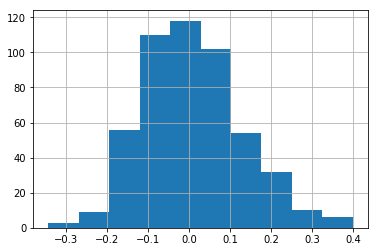

In [127]:
# Sample level, uncorrected
effect_sizes['sample_lvl'].hist()

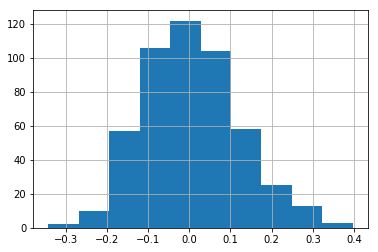

In [128]:
# Subsample level, uncorrected
effect_sizes['sub_sample_lvl'].hist()

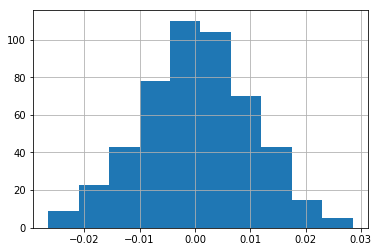

In [129]:
# Sample level, Cuped-corrected
effect_sizes['sample_lvl_corrected'].hist()

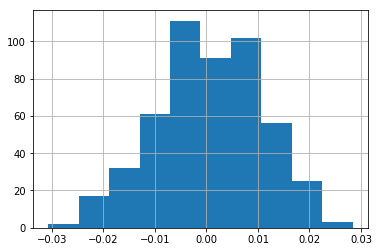

In [130]:
# Subsample level, Cuped-corrected
effect_sizes['sub_sample_lvl_corrected'].hist()

Conclusion: CUPED definitely helps (but we already knew this). However, there seems to be no difference between evaluating the treatment effect on the sub-samples or on the samples (with the coinflip in both cases on the sample level)...